In [1]:
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

In [2]:
df0 = pd.read_csv('./data/raw/train.csv')
print(df0.shape)

(206474, 76)


### Отсекаю слишком дорогую недвижимость и слишком дешёвую недвижимость

(198367, 76)


<AxesSubplot:>

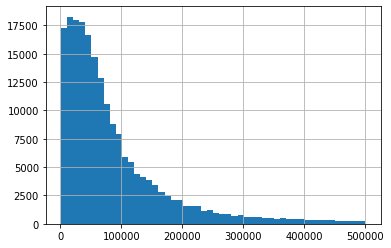

In [12]:
df1 = df0[(df0['per_square_meter_price'] > 1000) & (df0['per_square_meter_price'] < 0.5e6)]
print(df1.shape)
# Maybe df['per_square_meter_price'] > 1000 is useless
df1['per_square_meter_price'].hist(bins=50)

### Отсекаю города, которые слишком далеко от больших

In [4]:
df2 = df1[df1['osm_city_closest_dist'] < 100] # Мб не надо
print(df2.shape)

(192162, 76)


### Отсекаю города, в которых слишком мало предложений

In [5]:
df3 = df2.groupby('city').filter(lambda x: len(x) > 15)
print(df3.shape)

(182463, 76)


### Объединяю категории points

In [6]:
points_types = ['amenity_points', 'building_points', 'catering_points', 'crossing_points', 'culture_points',
                'finance_points', 'healthcare_points', 'historic_points', 'hotels_points', 'leisure_points',
                'offices_points', 'shops_points']
df4 = df3.copy()
for point_type in points_types:
       df4[point_type] = 16 * df3[f'osm_{point_type}_in_0.005'] + 8 * df3[f'osm_{point_type}_in_0.0075'] + 4 * df3[
              f'osm_{point_type}_in_0.01']
       df4 = df4.drop([f'osm_{point_type}_in_0.005', f'osm_{point_type}_in_0.0075', f'osm_{point_type}_in_0.01'], axis=1)
       if f'osm_{point_type}_in_0.001' in df3.columns:
              df4[point_type] += 32 * df3[f'osm_{point_type}_in_0.001']
              df4 = df4.drop([f'osm_{point_type}_in_0.001'], axis=1)

### Кодирую realty_type с помощью ohe

In [7]:
df5 = df4.copy()
ohe = OneHotEncoder()
oheRealtyType = ohe.fit_transform(df5[['realty_type']])
realtyTypeCategories = list(map(lambda x: 'realty_type_' + str(x),  ohe.categories_[0]))
df5[realtyTypeCategories] = oheRealtyType.toarray()
df5 = df5.drop(['realty_type'], axis=1)

### Логарифмирую цену за квадратный метр

In [8]:
from math import log2

df6 = df5.assign(
       per_square_meter_price = df5.per_square_meter_price.apply(log2)
)

print(df6.city)

0              Ставрополь
1                    Омск
2                Белгород
4             Новосибирск
5              Красноярск
               ...       
206469       Нижний Тагил
206470        Новосибирск
206471         Ставрополь
206472    Санкт-Петербург
206473       Екатеринбург
Name: city, Length: 182463, dtype: object


### Кодирую названия городов

In [9]:
df7 = df6.copy()

city_mapping = dict(
    zip(
        pd.unique(df7.city),
        range(0, len(pd.unique(df7.city)))
    )
)
df7.city = df7.city.apply(lambda it: city_mapping[it])
print(df7.shape)
print(df7.shape[0] / df0.shape[0])

(182463, 46)
0.8837093290196344


### Распределяю недвижимость по городам относительно численности населения

In [10]:
msk_spb = [city_mapping['Москва'], city_mapping['Санкт-Петербург']]
moscow_spb = df7[df7['city'].isin(msk_spb)]
print(moscow_spb.shape)
population_gt_1M = df7[(df7['osm_city_nearest_population'] >= 1e6) & (~df7['city'].isin(msk_spb))]
print(population_gt_1M.shape)
# TODO сделать больше категорий для малых городов, если точность предсказаний будет низкой (использовать сторонние источники с численностью населения городов, так как osm_city_nearest_population для малых городов не подходит)
population_lt_100K = df7[(df7['osm_city_nearest_population'] < 1e6) & (~df7['city'].isin(msk_spb))]
print(population_lt_100K.shape)
print(moscow_spb.shape[0] + population_gt_1M.shape[0] + population_lt_100K.shape[0])

(49475, 46)
(60098, 46)
(72890, 46)
182463


In [11]:
moscow_spb.to_csv('./data/processed/moscow_spb.csv', index=False)
population_gt_1M.to_csv('./data/processed/population_gt_1M.csv', index=False)
population_lt_100K.to_csv('./data/processed/population_lt_100K.csv', index=False)